# Data Description

The dataset consists of data scraped from __[PropertyGuru.com.my](https://www.propertyguru.com.my/new-property-launch)__ on 1st February 2024. Property.com.my is one of the most comprehensive Malaysia Property website. The dataset contains detail information of new property listed for sell on the website. The objective is to analyze the housing property listed on the website.

### About the Dataset

- __title__ -  Title
- __status__ - Status, example New Launch, Open for Sale etc
- __type__ - Type, example Apartment, Condominium, etc
- __tenure__ - Tenure, example Freehold, Leasehold etc
- __price__ - Price in RM
- __built_up_size__ - Built up size in square feet
- __bedroom__ - Number of bedroom
- __bathroom__ - Number of bathroom
- __car_park__ - Number of car park
- __address__ - Address
- __description__ - Description
- __link__ - Link to project information

In [1]:
# import required packages
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt

# to display chart correctly
%matplotlib inline

### Understand the Dataset

In [2]:
date = '2024-02-01'
# read the dataset to data frame
df = pd.read_csv(f'..\data\iproperty_new_listed_projects_{date}.csv')

# see the data structure from first 5 rows
df.head()

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,address,description,link
0,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,473499.0,953 sq. ft.,3,2,2,"Kota Kemuning, Shah Alam, Selangor",Ready to Move In! Register today and save on C...,https://www.iproperty.com.my/new-property/prop...
1,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,555579.0,"1,068 sq. ft.",3,2,2,"Kota Kemuning, Shah Alam, Selangor",Ready to Move In! Register today and save on C...,https://www.iproperty.com.my/new-property/prop...
2,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,582084.0,"1,180 sq. ft.",4,4,2,"Kota Kemuning, Shah Alam, Selangor",Ready to Move In! Register today and save on C...,https://www.iproperty.com.my/new-property/prop...
3,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,676800.0,1464,4,3,2,"Kajang, Selangor","Nestled amidst lush hills, JHomes is a low-den...",https://www.iproperty.com.my/new-property/prop...
4,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,678800.0,1464,4,3,2,"Kajang, Selangor","Nestled amidst lush hills, JHomes is a low-den...",https://www.iproperty.com.my/new-property/prop...


In [3]:
# check the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          281 non-null    object 
 1   status         281 non-null    object 
 2   type           281 non-null    object 
 3   tenure         281 non-null    object 
 4   land_title     281 non-null    object 
 5   price          281 non-null    float64
 6   built_up_size  281 non-null    object 
 7   bedroom        281 non-null    int64  
 8   bathroom       281 non-null    int64  
 9   car_park       281 non-null    int64  
 10  address        281 non-null    object 
 11  description    281 non-null    object 
 12  link           281 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 28.7+ KB


This dataset contains 281 rows and there is no null value in the dataset.
Data type for some columns need to be corrected
- title, object to string
- status, object to string
- type, object to string
- tenure, object to string
- land_title, object to string
- address, object to string
- built_up_size, object to int64

Description can be used in WorldCloud visualization but not in the analysis here.
We can drop the columns for description and link since these columns are not needed for the analyze here.

In [4]:
# check for the value counts for status
df.status.value_counts()

status
New Launch                           146
Open for Sale                         76
Open for Registration                 33
Completed Project                     23
Open for SaleGreat Property Deals      3
Name: count, dtype: int64

3 rows with status "Open for SaleGreat Property Deals" and this sentence looks like a combination of "Open for Sale" and "Great Property Deals". We can go to the project link and check whether this is a data issue and change the status accordingly.

In [5]:
# check for the value counts for type
df.type.value_counts()

type
Serviced Residence          71
2-sty Terrace/Link House    68
Condominium                 39
Apartment                   25
Semi-detached House         20
Shop Office                 14
Bungalow                     8
1-sty Terrace/Link House     6
Townhouse                    5
Shop                         4
Detached factory             4
Industrial Land              3
Cluster House                3
Soho                         3
Semi-D factory               2
Suites                       2
4-sty Terrace/Link House     2
Sovo                         1
Office                       1
Name: count, dtype: int64

We can add one column to categorize property type to "House", "Factory", "Land" and "Shop or Office"

In [6]:
# check for the value counts for tenure
df.tenure.value_counts()

tenure
Freehold               188
Leasehold               84
Lease Tenancy            3
Unknown                  3
Lease                    2
Malay Reserved Land      1
Name: count, dtype: int64

We can change the tenure for "Lease Tenancy" and "Lease" to "Leasehold".<br>
We can also get the property information from link for rows with "Unknown" tenure and correct it.

In [7]:
# check for the value counts for tenure
df.land_title.value_counts()

land_title
Residential    183
Commercial      80
Industrial       9
Unknown          9
Name: count, dtype: int64

We can also get the property information from link for rows with "Unknown" land title and correct it.

### Preprocess the Dataset

In [8]:
# change the data type object to string
df.title = df.title.astype('string')
df.status = df.status.astype('string')
df.type = df.type.astype('string')
df.tenure = df.tenure.astype('string')
df.land_title = df.land_title.astype('string')
df.address = df.address.astype('string')

In [9]:
# change the data type object to int64
# from head we noticed that first 3 rows of build_up_size contains string value
def get_built_up_size(text):
    # value of build up size in the data can be in any 
    # following format, "953 sq. ft.", "1,180 sq. ft.", 
    # "From 1,200 sq. ft.", "1,778 - 2,137 sqft"
    # "2,322 – 2,442 sqft", "1,047 / 1,096 sq. ft."
    text = re.sub(r'[^0-9-–/]', '', text)
    # get the left (min) value
    match = re.search(r'\D*(\d+)', text)
    text = match.group(1)
    return int(text)

df.built_up_size = df.built_up_size.apply(lambda row: get_built_up_size(row))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          281 non-null    string 
 1   status         281 non-null    string 
 2   type           281 non-null    string 
 3   tenure         281 non-null    string 
 4   land_title     281 non-null    string 
 5   price          281 non-null    float64
 6   built_up_size  281 non-null    int64  
 7   bedroom        281 non-null    int64  
 8   bathroom       281 non-null    int64  
 9   car_park       281 non-null    int64  
 10  address        281 non-null    string 
 11  description    281 non-null    object 
 12  link           281 non-null    object 
dtypes: float64(1), int64(4), object(2), string(6)
memory usage: 28.7+ KB


In [10]:
# check property information with the link for "Open for SaleGreat Property Deals" status 
pd.set_option('display.max_colwidth', None)
print(df[df.status=='Open for SaleGreat Property Deals'].link)
pd.set_option('display.max_colwidth', 20)

243    https://www.iproperty.com.my/new-property/property/petaling-jaya/the-atera-petaling-jaya/new-6546/
244    https://www.iproperty.com.my/new-property/property/petaling-jaya/the-atera-petaling-jaya/new-6546/
245    https://www.iproperty.com.my/new-property/property/petaling-jaya/the-atera-petaling-jaya/new-6546/
Name: link, dtype: object


In [11]:
# status for the rows with status "Open for SaleGreat Property Deals" is "Open for Sale" from the property information page
# change the status to "Open for Sale"
df.loc[df.status == 'Open for SaleGreat Property Deals', 'status'] = 'Open for Sale'
df.status.value_counts()

status
New Launch               146
Open for Sale             79
Open for Registration     33
Completed Project         23
Name: count, dtype: Int64

In [12]:
# add one column to categorize property type to "House", "Factory", "Land" and "Shop or Office"
def get_propert_type(text):
    if text in ('Detached factory', 'Semi-D factory'):
        return "Factory"
    elif text in ('Shop Office', 'Shop', 'Sovo', 'Office'):
        return "Shop or Office"
    elif text in ('Industrial Land'):
        return "Land"    
    else:
        # note that for this EDA we consider Soho as house
        # although it can be used as office also
        return "House"

df['category']= df.type.apply(lambda row: get_propert_type(row))
df.category.value_counts()

category
House             252
Shop or Office     20
Factory             6
Land                3
Name: count, dtype: int64

In [13]:
# change the tenure for "Lease Tenancy" and "Lease" to "Leasehold".
df.loc[df.tenure == 'Lease Tenancy', 'tenure'] = 'Leasehold'
df.loc[df.tenure == 'Lease', 'tenure'] = 'Leasehold'

In [14]:
# check property information with the link for "Unknown" tenure
pd.set_option('display.max_colwidth', None)
print(df[df.tenure=='Unknown'].link)
pd.set_option('display.max_colwidth', 20)

221    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
222    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
223    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
Name: link, dtype: object


In [15]:
# tenure from iProperty property information page is Unknown
# googled the propety information showing the tenure is Leasehold
df.loc[df.tenure == 'Unknown', 'tenure'] = 'Leasehold'
df.tenure.value_counts()

tenure
Freehold               188
Leasehold               92
Malay Reserved Land      1
Name: count, dtype: Int64

In [16]:
# check property information with the link for "Unknown" land title
pd.set_option('display.max_colwidth', None)
print(df[df.land_title=='Unknown'].link)
pd.set_option('display.max_colwidth', 20)

35               https://www.iproperty.com.my/new-property/property/nilai/nilai-impian-emilia-3/new-6510/
36               https://www.iproperty.com.my/new-property/property/nilai/nilai-impian-emilia-3/new-6510/
37               https://www.iproperty.com.my/new-property/property/nilai/nilai-impian-emilia-3/new-6510/
54              https://www.iproperty.com.my/new-property/property/kl-city/legasi-kampong-bharu/new-5936/
55              https://www.iproperty.com.my/new-property/property/kl-city/legasi-kampong-bharu/new-5936/
56              https://www.iproperty.com.my/new-property/property/kl-city/legasi-kampong-bharu/new-5936/
221    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
222    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
223    https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a/new-6636/
Name: link, dtype: object


In [17]:
# land title from iProperty property information page is Unknown
# googled the propety information showing land title is Residential
df.loc[df.land_title == 'Unknown', 'land_title'] = 'Residential'
df.land_title.value_counts()

land_title
Residential    192
Commercial      80
Industrial       9
Name: count, dtype: Int64

In [18]:
# add city and state columns
def get_city(text):
    split_items = text.split(',')
    city = split_items[-2]
    state = split_items[-1]

df['city']= df.address.apply(lambda row: row.split(',')[-2].strip())
df['state']= df.address.apply(lambda row: row.split(',')[-1].strip())

In [19]:
df.city.value_counts()

city
Shah Alam                     26
Johor Bahru                   17
Iskandar Puteri (Nusajaya)    14
Semenyih                      14
Petaling Jaya                 12
Puchong                       11
Subang Jaya                   10
Kajang                        10
Rawang                        10
Kuala Langat                   9
KL City                        7
Pasir Gudang                   7
Bangsar                        6
Gelang Patah                   6
Mont Kiara                     6
Bandar Puncak Alam             6
Cyberjaya                      6
Seri Kembangan                 6
Ampang Hilir                   6
Sepang                         6
Nilai                          6
Setapak                        6
Bayan Lepas                    5
Labu                           4
Bukit Bintang                  4
Muar                           3
Kota Kinabalu                  3
Mount Austin                   3
Kepala Batas                   3
Pulau Langkawi                 3
Kayu 

In [20]:
df.state.value_counts()

state
Selangor           148
Johor               59
Kuala Lumpur        38
Penang              14
Negeri Sembilan     13
Sabah                3
Kedah                3
Terengganu           2
Pahang               1
Name: count, dtype: int64

In [21]:
# check is there any anomalies in the data with describe for numerical data
df.describe()

,price,built_up_size,bedroom,bathroom,car_park
count,2.810000e+02,281.000000,281.000000,281.000000,281.000000
mean,1.076786e+06,2028.950178,2.843416,2.651246,1.476868
std,9.912908e+05,2247.150346,1.501321,1.565045,1.406744
min,1.200000e+05,223.000000,0.000000,0.000000,0.000000
25%,5.890000e+05,956.000000,2.000000,2.000000,0.000000
50%,8.100000e+05,1647.000000,3.000000,3.000000,2.000000
75%,1.280800e+06,2285.000000,4.000000,4.000000,2.000000
max,8.650000e+06,20013.000000,7.000000,8.000000,9.000000


- minimum value for bedroom is 0 and this need to be investigated and corrected if necessary.
- minimum value for bathroom is 0 and this need to be investigated and corrected  if necessary
- minimum value for car park is 0. It is observed that even 25th percentile for the number of car park is 0, it seems quite a number of developers do not provide car park information for their projects.

In [22]:
# check property information with the link for bedroom is 0 for housing properties only
df_room = df[df.category=='House']
df_room = df_room[df_room.bedroom==0]
df_room = df_room[['title', 'price', 'built_up_size', 'link']].copy()
pd.set_option('display.max_colwidth', None)
print(df_room)
pd.set_option('display.max_colwidth', 20)

                                title     price  built_up_size  \
77          The Nobel Healthcare Park  338000.0            268   
78          The Nobel Healthcare Park  414000.0            223   
118  Glomac Centro Serviced Apartment  909865.0           1670   
119  Glomac Centro Serviced Apartment  733015.0           1279   
120  Glomac Centro Serviced Apartment  774190.0           1279   
221         Tropicana Alam - Phase 1A  678800.0           1917   
222         Tropicana Alam - Phase 1A  988800.0           2239   
223         Tropicana Alam - Phase 1A  783800.0           1962   

                                                                                                       link  
77       https://www.iproperty.com.my/new-property/property/bukit-jalil/the-nobel-healthcare-park/new-6400/  
78       https://www.iproperty.com.my/new-property/property/bukit-jalil/the-nobel-healthcare-park/new-6400/  
118  https://www.iproperty.com.my/new-property/property/kayu-ara/glomac-cen

In [23]:
df.iloc[77, df.columns.get_loc('bedroom')] = 1
df.iloc[78, df.columns.get_loc('bedroom')] = 1
df.iloc[118, df.columns.get_loc('bedroom')] = 4
df.iloc[119, df.columns.get_loc('bedroom')] = 3
df.iloc[120, df.columns.get_loc('bedroom')] = 3
df.iloc[221, df.columns.get_loc('bedroom')] = 4
df.iloc[222, df.columns.get_loc('bedroom')] = 4
df.iloc[223, df.columns.get_loc('bedroom')] = 4

In [24]:
# check property information with the link for bathroom is 0 for housing properties only
df_bathroom = df[df.category=='House']
df_bathroom = df_bathroom[df_bathroom.bathroom==0]
df_bathroom = df_bathroom[['title', 'price', 'built_up_size', 'link']].copy()
pd.set_option('display.max_colwidth', None)
print(df_bathroom)
pd.set_option('display.max_colwidth', 20)

                                title     price  built_up_size  \
118  Glomac Centro Serviced Apartment  909865.0           1670   
119  Glomac Centro Serviced Apartment  733015.0           1279   
120  Glomac Centro Serviced Apartment  774190.0           1279   
221         Tropicana Alam - Phase 1A  678800.0           1917   
222         Tropicana Alam - Phase 1A  988800.0           2239   
223         Tropicana Alam - Phase 1A  783800.0           1962   

                                                                                                       link  
118  https://www.iproperty.com.my/new-property/property/kayu-ara/glomac-centro-serviced-apartment/new-2098/  
119  https://www.iproperty.com.my/new-property/property/kayu-ara/glomac-centro-serviced-apartment/new-2098/  
120  https://www.iproperty.com.my/new-property/property/kayu-ara/glomac-centro-serviced-apartment/new-2098/  
221      https://www.iproperty.com.my/new-property/property/kuala-langat/tropicana-alam-phase-1-a

In [25]:
df.iloc[118, df.columns.get_loc('bathroom')] = 3
df.iloc[119, df.columns.get_loc('bathroom')] = 2
df.iloc[120, df.columns.get_loc('bathroom')] = 2
df.iloc[221, df.columns.get_loc('bathroom')] = 3
df.iloc[222, df.columns.get_loc('bathroom')] = 4
df.iloc[223, df.columns.get_loc('bathroom')] = 3

In [26]:
# drop unused columns
df.drop(['address', 'link', 'description'], axis=1, inplace=True)
df.head()

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state
0,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,473499.0,953,3,2,2,House,Shah Alam,Selangor
1,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,555579.0,1068,3,2,2,House,Shah Alam,Selangor
2,Amverton Greens,Open for Sale,Apartment,Freehold,Residential,582084.0,1180,4,4,2,House,Shah Alam,Selangor
3,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,676800.0,1464,4,3,2,House,Kajang,Selangor
4,JHomes,Open for Sale,Serviced Residence,Freehold,Residential,678800.0,1464,4,3,2,House,Kajang,Selangor


In [27]:
# some of the iProperty project information pages consist dirty data that will result in duplication of records
# check is the data frame contains any duplicated records
df[df.duplicated()]

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state
10,Maya Ara Residences,New Launch,Serviced Residence,Freehold,Commercial,594800.0,764,2,2,0,House,Ara Damansara,Selangor
28,Ilham Residence 3,New Launch,2-sty Terrace/Li...,Freehold,Residential,903888.0,1964,4,4,2,House,Shah Alam,Selangor
140,J.Satine Residen...,New Launch,Apartment,Leasehold,Commercial,300000.0,800,3,2,1,House,Setapak,Kuala Lumpur
157,Casablanca 3,Open for Sale,Cluster House,Freehold,Residential,1702800.0,3048,4,5,2,House,Shah Alam,Selangor
167,"Phase 6M, Rini H...",Open for Sale,2-sty Terrace/Li...,Leasehold,Residential,672000.0,2280,4,4,0,House,Skudai,Johor
169,Isadora,New Launch,2-sty Terrace/Li...,Freehold,Residential,1158000.0,2266,4,4,4,House,Cyberjaya,Selangor
209,Serai Avenue 2 &...,Open for Registr...,Shop Office,Leasehold,Commercial,1368000.0,2656,0,4,0,Shop or Office,Rawang,Selangor
244,"The Atera, Petal...",Open for Sale,Serviced Residence,Leasehold,Commercial,633800.0,775,2,2,0,House,Petaling Jaya,Selangor
274,Setia Versa,Open for Sale,Detached factory,Freehold,Industrial,7700000.0,20013,0,0,0,Factory,Gelang Patah,Johor


In [28]:
# remove duplicated records from data frame
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state


In [29]:
# save the processed data frame to csv file
df.to_csv(f'..\data\iproperty_new_listed_projects_{date}_eda.csv', sep=',', encoding='utf-8', index=False)

### Analyze the Dataset

In [30]:
# we only interested on housing price, get house category from the data frame
df_house = df[df.category=='House']

In [31]:
df_house.describe(include='all')

,title,status,type,tenure,land_title,price,built_up_size,bedroom,bathroom,car_park,category,city,state
count,245,245,245,245,245,2.450000e+02,245.000000,245.000000,245.000000,245.000000,245,245,245
unique,107,4,12,3,2,NaN,NaN,NaN,NaN,NaN,1,47,9
top,Amverton Greens,New Launch,Serviced Residence,Freehold,Residential,NaN,NaN,NaN,NaN,NaN,House,Shah Alam,Selangor
freq,3,137,69,163,188,NaN,NaN,NaN,NaN,NaN,245,23,139
mean,NaN,NaN,NaN,NaN,NaN,1.002234e+06,1701.742857,3.265306,2.946939,1.628571,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,6.741138e+05,970.091239,1.097230,1.324904,1.407241,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,2.000000e+05,223.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,5.820840e+05,955.000000,3.000000,2.000000,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,8.058880e+05,1510.000000,4.000000,3.000000,2.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.255000e+06,2197.000000,4.000000,4.000000,2.000000,NaN,NaN,NaN


- this housing dataset contains 107 property projects
- median value for housing price is RM804,544, maximum is RM4,248,800 and minimum is RM200,000. More than RM4,000,000 difference between the maximum and minimum price.
- median value for built up size is 1,537.50 square feet, maximum is 5,640.00 square feet and minimum is 223.00 square feet. More than 5,000 square feet difference between the maximum and minimum built up size.
- median value for number of bedroom is 3, maximum is 7 and minimum is 1.
- median value for number of bathroom is 3, maximum is 8 and minimum is 1.
- median value for number of car park is 2, maximum is 9 and minimum is 0. It is observed that even 25th percentile for the number of car park is 0, it seems quite a number of developers do not provide car park information for their projects.

In [32]:
# filter unique property projects
df_project = df_house.copy()
# drop information related to unit type
df_project.drop(['price', 'built_up_size', 'bedroom', 'bathroom', 'car_park'], axis=1, inplace=True)
# drop duplicated rows
df_project.drop_duplicates(inplace=True)
pd.set_option('display.max_colwidth', 30)
df_project.describe(include='all')

,title,status,type,tenure,land_title,category,city,state
count,107,107,107,107,107,107,107,107
unique,107,4,12,3,2,1,47,9
top,Amverton Greens,New Launch,2-sty Terrace/Link House,Freehold,Residential,House,Shah Alam,Selangor
freq,1,60,30,71,80,107,10,61


- 56.07% of this housing dataset is new launch projects
- 28.04% of this housing dataset is 2-sty terrace/link house
- 66.36% of this housing dataset is freehold
- 74.77% of this housing dataset with residential land title
- 9.35% of this housing dataset in Shah Alam city
- 57.01% of this housing dataset in Selangor state

In [33]:
def plot_pie_chart(data, target_column, title):
    target = data[target_column].value_counts().reset_index(name='total')
    plt.pie(
        x=target['total'], 
        labels=target[target_column],
        autopct='%1.2f%%',
        colors=sns.color_palette('colorblind'),
        startangle=90,
        wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
    )
    plt.tight_layout()
    plt.title(title)
    plt.show() 


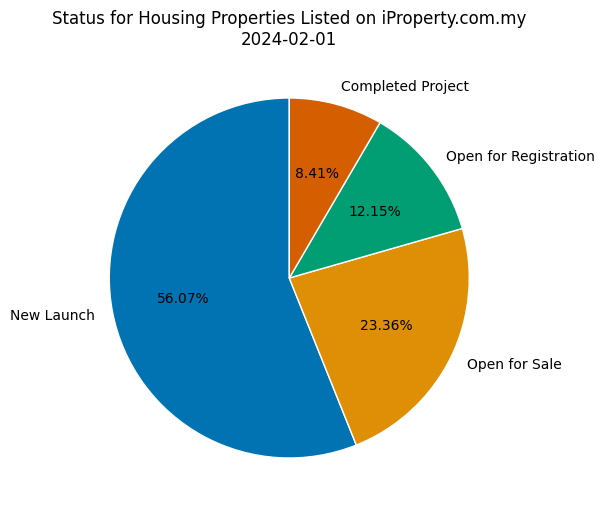

In [34]:
plot_pie_chart(df_project, 'status', f"Status for Housing Properties Listed on iProperty.com.my\n{date}")

Nearly 80% of the housing properties listed on iProperty.com.my are new launch and open for sale property with 56.07% of new launch property and 23.36% of open for sale property. 

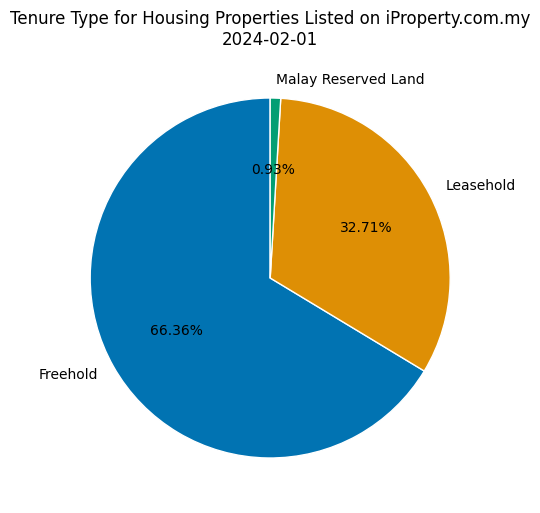

In [35]:
plot_pie_chart(df_project, 'tenure', f"Tenure Type for Housing Properties Listed on iProperty.com.my\n{date}")

More than 90% of the housing properties listed on iProperty.com.my are freehold and leasehold property with 66.36% of freehold property and 32.71% of leasehold property.

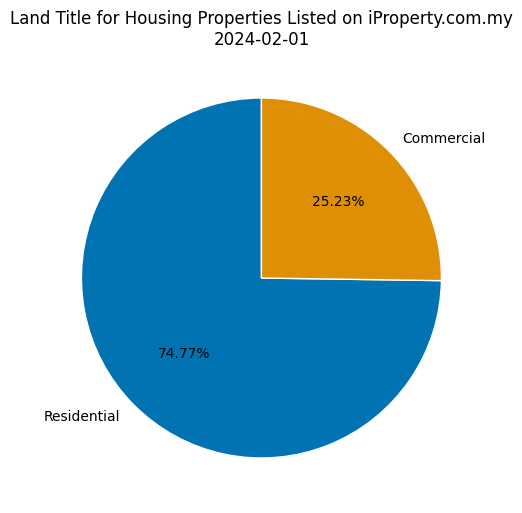

In [36]:
plot_pie_chart(df_project, 'land_title', f"Land Title for Housing Properties Listed on iProperty.com.my\n{date}")

Close to two thirds of the housing properties listed on iProperty.com.my are residential land title.

In [37]:
def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=True).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column, 
        hue=target_column,
        palette='colorblind',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation="vertical")
    plt.tick_params(axis='both', which='major', labelsize=9)
    # show percentage on bar for first 3 bars
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)
        if index == 2:
            break
    plt.show()

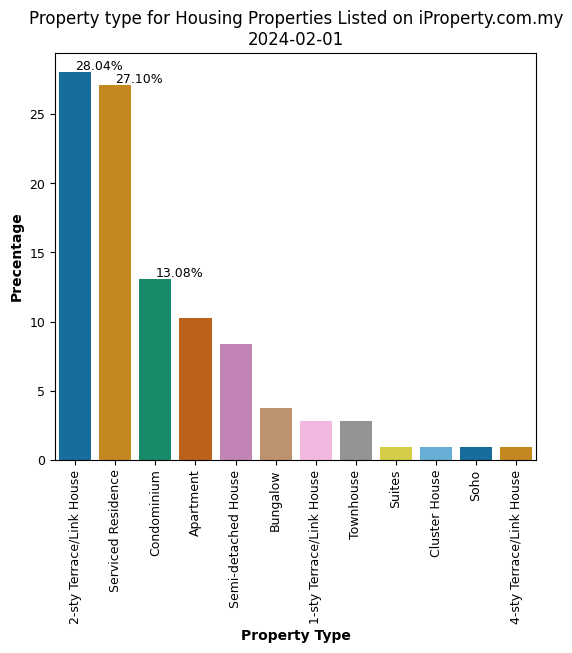

In [38]:
plot_bar_chart(df_project, 'type', f"Property type for Housing Properties Listed on iProperty.com.my\n{date}", 'Property Type', 'Precentage')

Top 3 property types listed on iProperty.com.my are 2-sty terrace/link house 28.04%, service residence 27.10% and condominium 13.08%.

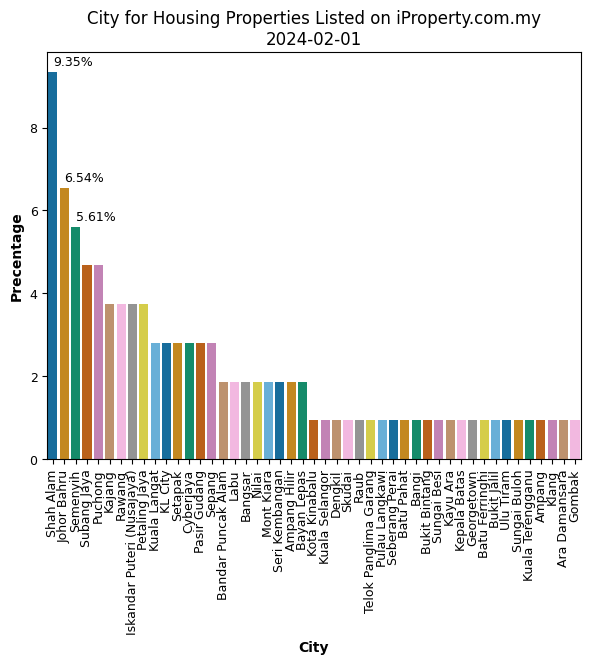

In [39]:
plot_bar_chart(df_project, 'city', f"City for Housing Properties Listed on iProperty.com.my\n{date}", 'City', 'Precentage')

For housing properties
listed on iProperty.com.my, top 3 cities are Shah Alam 9.35%, Johor Bahru 6.54% and Semenyih 5.61%. Top 10 cities are in Selangor and Johor.

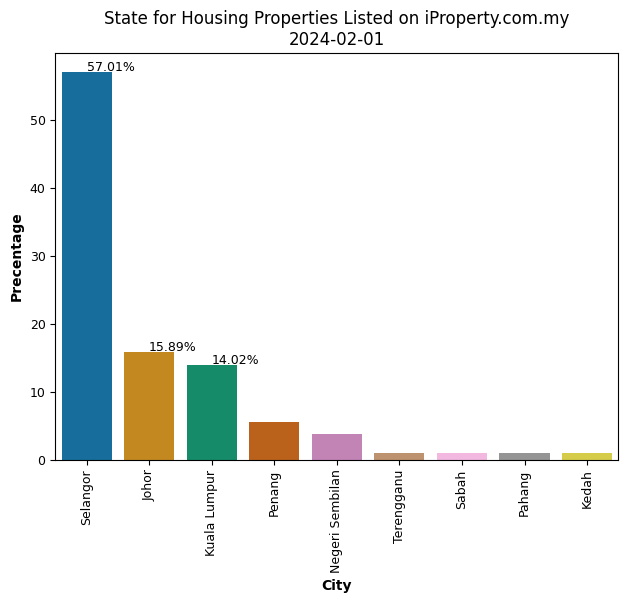

In [40]:
plot_bar_chart(df_project, 'state', f"State for Housing Properties Listed on iProperty.com.my\n{date}", 'City', 'Precentage')

For housing properties listed on iProperty.com.my, top 3 states are Selangor 57.01%, Johor 15.89% and Kuala Lumpur 14.02%. More than half of the housing properties listed on iProperty.com.my are in Selangor state. Terengganu, Sabah, Pahang, and Kedah only have one property projet listed on iProperty.com.my.

In [41]:
def plot_price_hist(data, y_mean_annotate, y_median_annotate, title):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)
    fig.tight_layout()
    tick_spacing=250_000 # set spacing for each tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    figplot = sns.histplot(ax=ax, data=data.price, kde=True, bins=100)
    figplot.set_title(title)
    figplot.set_xlabel("Price (RM)", fontdict={'weight': 'bold'})
    figplot.set_ylabel("Number of Properties", fontdict={'weight': 'bold'})
    figplot.axvline(data.price.median(), c='darkorange')
    figplot.annotate(f'Median (RM{data.price.median():,.2f})', 
                     xy=(data.price.median(), y_median_annotate), 
                     xytext=(data.price.median() + 2 * tick_spacing, y_median_annotate - 0.5), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
    figplot.axvline(data.price.mean(), c='darkorange')
    figplot.annotate(f'Mean (RM{data.price.mean():,.2f})', 
                     xy=(data.price.mean(), y_mean_annotate), 
                     xytext=(data.price.mean() + 2 * tick_spacing, y_mean_annotate - 0.5), 
                     fontsize=10,
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
    plt.show()

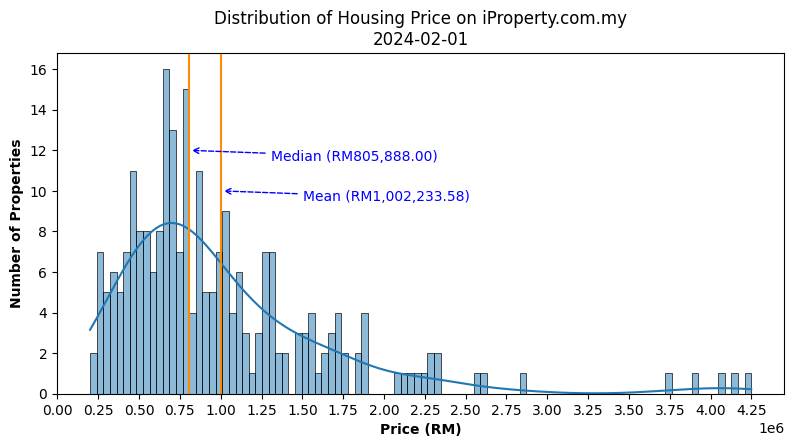

In [42]:
# plot price distribution
plot_price_hist(df_house, 10, 12, f"Distribution of Housing Price on iProperty.com.my\n{date}")

Housing price distribution is skewed to the right. Most of the price for housing properties listed on iProperty.com.my in RM250,000 to RM1,250,000 range. It is observed that there is no housing properties listed on iProperty.com.my for the price between ~RM2.87 millions and ~Rm3.70 millions.

End of upper whisker: 2264374.0


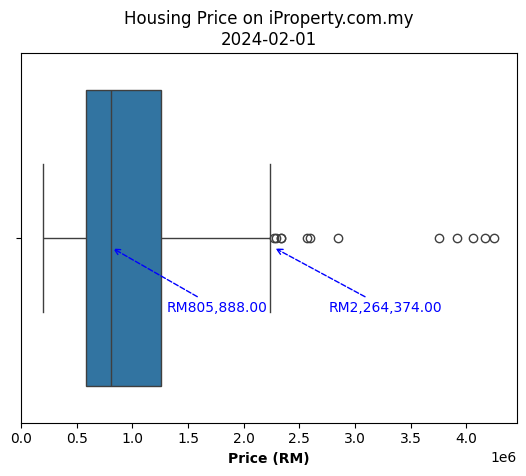

In [43]:
# remove outliers with the value at the end of upper whisker
figplot = sns.boxplot(data=df_house, x='price')
upper_quartile = df_house.price.quantile(0.75)
lower_quartile = df_house.price.quantile(0.25)
iqr = upper_quartile - lower_quartile
upper_whisker_end = upper_quartile + 1.5 * iqr
figplot.annotate(f'RM{upper_whisker_end:,.2f}', 
                     xy=(upper_whisker_end, 0.025), 
                     xytext=(upper_whisker_end + 2 * 250_000, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
price_median = df_house.price.median()
figplot.annotate(f'RM{price_median:,.2f}', 
                     xy=(price_median, 0.025), 
                     xytext=(price_median + 2 * 250_000, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
figplot.set_title(f"Housing Price on iProperty.com.my\n{date}")
figplot.set_xlabel("Price (RM)", fontdict={'weight': 'bold'})
print(f'End of upper whisker: {upper_whisker_end}')

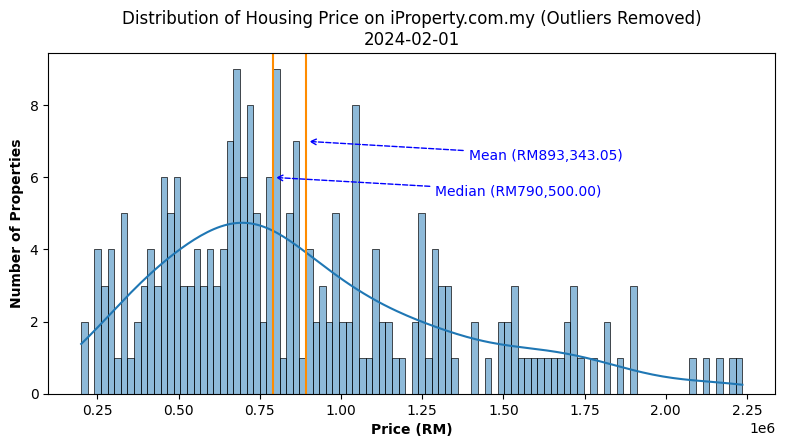

In [44]:
# plot price distribution with properties with price > RM2.87 millions removed
df_house_price_remove_outliers = df_house[df_house.price < upper_whisker_end]
plot_price_hist(df_house_price_remove_outliers, 7, 6, f"Distribution of Housing Price on iProperty.com.my (Outliers Removed)\n{date}")

In [45]:
median_mean_diff_before_remove_outliers = df_house.price.mean() - df_house.price.median()
median_mean_diff_after_remove_outliers = df_house_price_remove_outliers.price.mean() - df_house_price_remove_outliers.price.median()
print(f'Difference between median and mean for housing price before removing outliers: {median_mean_diff_before_remove_outliers:,.2f}')
print(f'Difference between median and mean for housing price after removing removing outliers: {median_mean_diff_after_remove_outliers:,.2f}')

Difference between median and mean for housing price before removing outliers: 196,345.58
Difference between median and mean for housing price after removing removing outliers: 102,843.05


With the removal of the properties with price > RM2,264,374, mean value is closer to median value although there is still with RM102,843.05 difference.

In [46]:
def plot_price_box(data, y, ylabel, title, ylabel_rotation):
    fig, ax = plt.subplots()
    fig.tight_layout()
    figplot = sns.boxplot(data=df_house, x='price', y=y, hue=y)
    figplot.set_title(title)
    figplot.set_xlabel("Price (RM)", fontdict={'weight': 'bold'})
    figplot.set_ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.yticks(rotation=ylabel_rotation)
    plt.show()

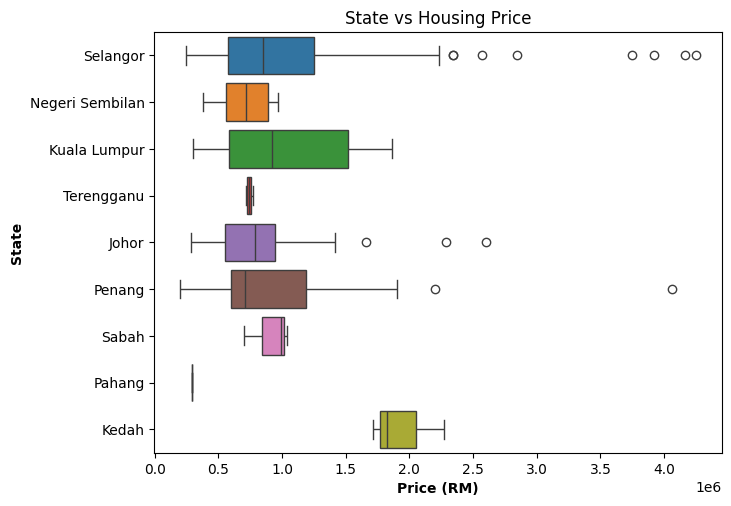

In [47]:
plot_price_box(df_house, 'state', 'State', "State vs Housing Price", 0) 

From previous analyse we know that Terengganu, Sabah, Pahang, and Kedah only have one property projet listed on iProperty.com.my, hence distribution of box plot for these states do not provide much information. It is observed also the price range for the project in Kedah and Sabah varies widely depending on the unit type. Kuala Lumpur has the highest median price value, RM922,5000. As Kuala Lumpur is the most developed state in Malaysia, and thus has the highest housing demand. Housing price for Kuala Lumpur is also more dispersed compared to other states. Selangor has the second highest median price value, RM851,000 as it is next to Kuala Lumpur and also one of the developed state in Malaysia. Johor has the third highest median price vlaue, RM790,500 due to it strategic location that near to Singapore and being one of the top choice of location for Malaysia My Second Home (MM2H). It is worth to note also the 25th percentile for all the states are above RM500,000.

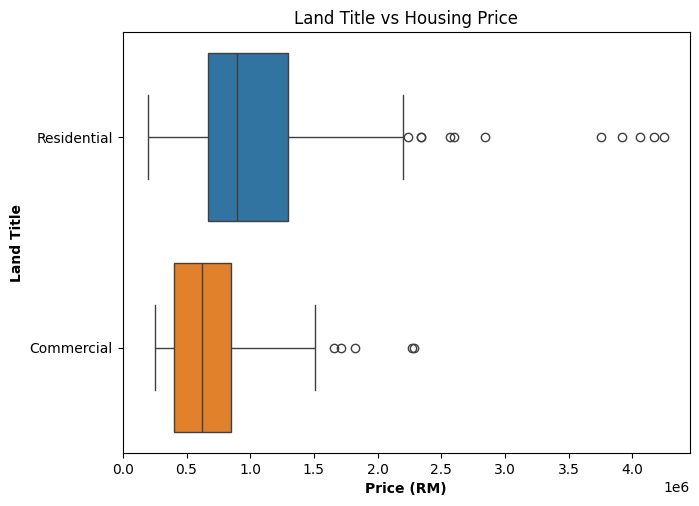

In [48]:
plot_price_box(df_house, 'land_title', 'Land Title', "Land Title vs Housing Price", 0) 

Overall housing price for residential land title is higher than commercial land title, suggesting that there might be an association between land title and housing price. Median price value for residential land title is higher than 75th percentile price value of commercial land title. Price value for property with residential land title is more dispersed than property with commercial land title.

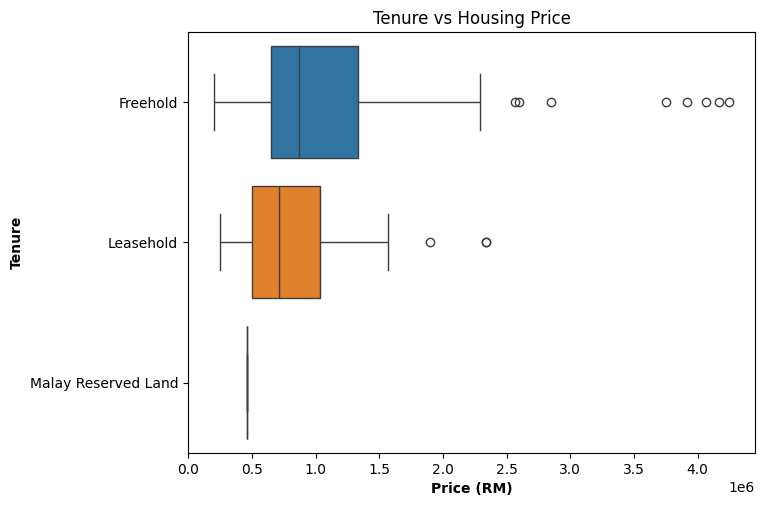

In [49]:
plot_price_box(df_house, 'tenure', 'Tenure', "Tenure vs Housing Price", 0) 

There is only property project with Malay reserved land tenure and hence hence its distribution does not provide much information. Overall the housing for price for freehold properties is higher and dispersed than leasehold properties, suggesting that there might be an association between tenure type and housing price. Freehold properties are usually more expensive than leasehold properties, partly because of the higher demand on the market and risks attached to leasing for leasehold properties.

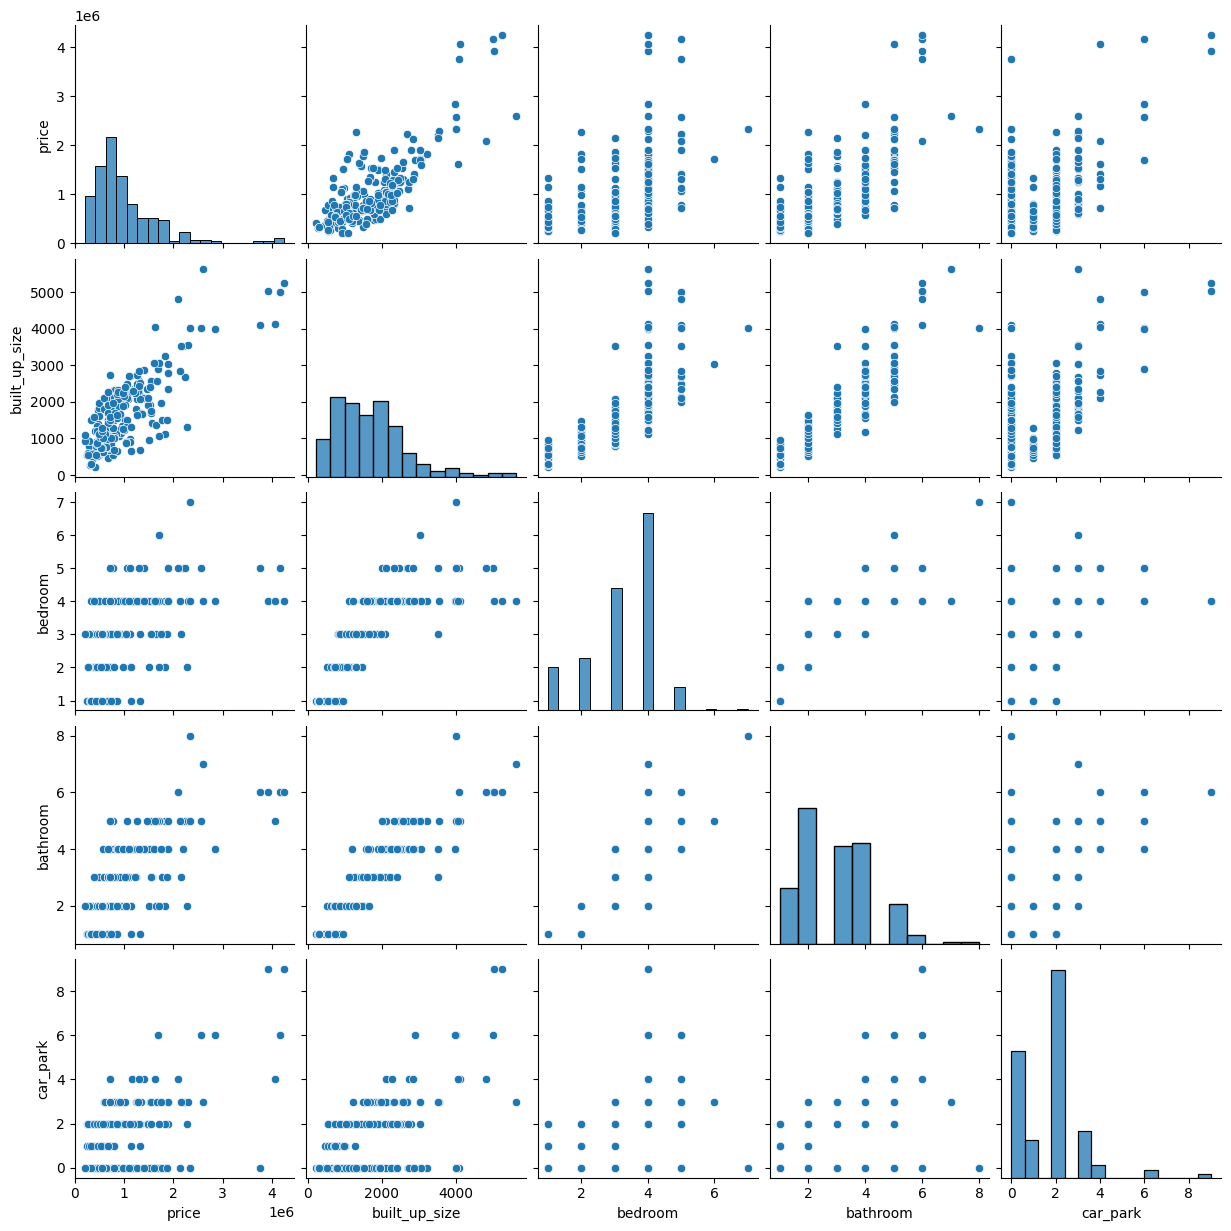

In [50]:
sns.pairplot(data=df_house)
plt.show()

From the scatter plots
- Price and built up size is positive correlated
- Price and number of bedroom is positive correlated
- Price and number of bathroom is positive correlated
- Price and number of car park is positive correlated
- Built up size and number of bedroom is positive correlated
- Built up size and number of bathroom is positive correlated
- Built up size and number of car park is positive correlated

In [51]:
# calculate Pearson correlation coefficient
import scipy.stats

print(f'Pearson correlation coefficient for price and build up size: {scipy.stats.pearsonr(df_house.price, df_house.built_up_size)[0]:.2f}')
print(f'Pearson correlation coefficient for price and number of bedroom: {scipy.stats.pearsonr(df_house.price, df_house.bedroom)[0]:.2f}')
print(f'Pearson correlation coefficient for price and number of bathroom: {scipy.stats.pearsonr(df_house.price, df_house.bathroom)[0]:.2f}')
print(f'Pearson correlation coefficient for price and number of car park: {scipy.stats.pearsonr(df_house.price, df_house.car_park)[0]:.2f}')
print('')
print(f'Pearson correlation coefficient for build up size and number of bedroom: {scipy.stats.pearsonr(df_house.built_up_size, df_house.bedroom)[0]:.2f}')
print(f'Pearson correlation coefficient for build up size and number of bathroom: {scipy.stats.pearsonr(df_house.built_up_size, df_house.bathroom)[0]:.2f}')
print(f'Pearson correlation coefficient for build up size and number of car park: {scipy.stats.pearsonr(df_house.built_up_size, df_house.car_park)[0]:.2f}')

Pearson correlation coefficient for price and build up size: 0.81
Pearson correlation coefficient for price and number of bedroom: 0.44
Pearson correlation coefficient for price and number of bathroom: 0.69
Pearson correlation coefficient for price and number of car park: 0.46

Pearson correlation coefficient for build up size and number of bedroom: 0.74
Pearson correlation coefficient for build up size and number of bathroom: 0.90
Pearson correlation coefficient for build up size and number of car park: 0.48


From Pearson correlation coefficient
- Price and built up size is positive strongly correlated 
- Price and number of bedroom is positive moderately correlated
- Price and number of bathroom is positive strongly correlated
- Price and number of car park is positive moderately correlated
- Built up size and number of bedroom is positive strongly correlated 
- Built up size and number of bathroom is positive strongly correlated 
- Built up size and number of car park is positive moderately correlated

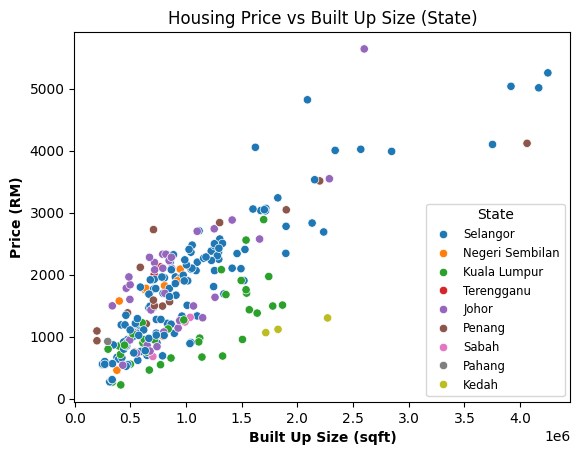

In [52]:
sns.scatterplot(data=df_house, x='price', y='built_up_size', hue='state')
plt.xlabel('Built Up Size (sqft)', fontdict={'weight': 'bold'})
plt.ylabel('Price (RM)', fontdict={'weight': 'bold'})
plt.title('Housing Price vs Built Up Size (State)')
plt.legend(title="State",loc=4, fontsize='small', fancybox=True)
plt.show()

Housing price is positive correlated with build up size is observed for different states.

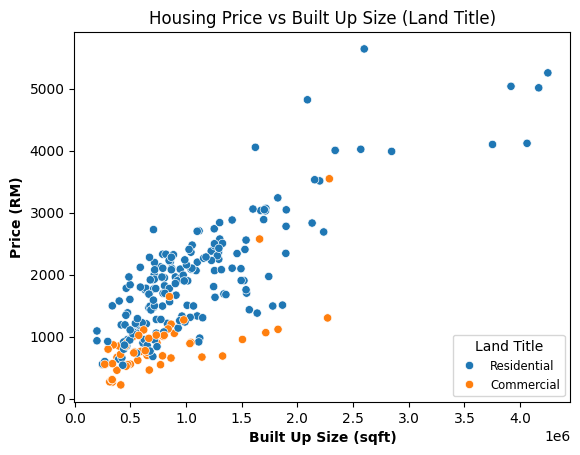

In [53]:
sns.scatterplot(data=df_house, x='price', y='built_up_size', hue='land_title')
plt.xlabel('Built Up Size (sqft)', fontdict={'weight': 'bold'})
plt.ylabel('Price (RM)', fontdict={'weight': 'bold'})
plt.title('Housing Price vs Built Up Size (Land Title)')
plt.legend(title="Land Title",loc=4, fontsize='small', fancybox=True)
plt.show()

Housing price is positive correlated with build up size is observed for different land titles.

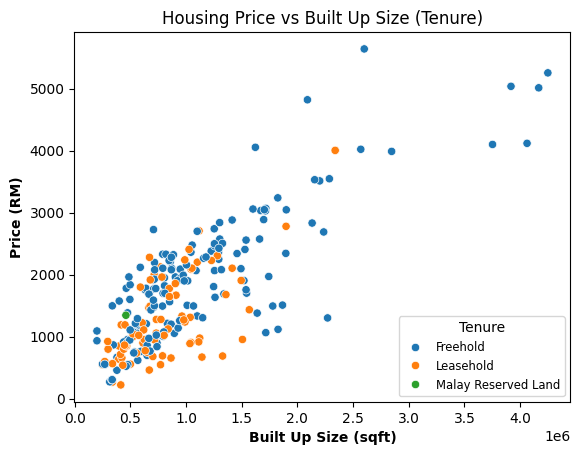

In [54]:
sns.scatterplot(data=df_house, x='price', y='built_up_size', hue='tenure')
plt.xlabel('Built Up Size (sqft)', fontdict={'weight': 'bold'})
plt.ylabel('Price (RM)', fontdict={'weight': 'bold'})
plt.title('Housing Price vs Built Up Size (Tenure)')
plt.legend(title="Tenure",loc=4, fontsize='small', fancybox=True)
plt.show()

Housing price is positive correlated with build up size is observed for different tenure types.